# Comparison of Model Performance

All models are compared based on their forecast performannce on the period from 2024-01-23 to 2025-02-28. (including two ends).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

- Forecast Error Metrics (MAE, RMSE, MASE)

- Diebold-Mariano Test (for forecast superiority)

- Visual Comparison (actual vs. predicted volatility)

One of the considerations was choosing a recursive estimation scheme over a rolling scheme in forecast estimation. While the latter is better suited for purposes like forecast comparison using DM test (which assumes that the differential is covariance stationary), the recursive estimation scheme is still favoured for practical reasons. This is because by expanding the training set timeframe, it uses more and more data to make later forecasts - parameter uncertainty is reduced, and forecast error may become less variable. Also, parameter estimation uncertainty typically constitutes a tiny fraction of forecast error variance, so reducing it would not noticeably violate stationarity. 

In [23]:
def get_qlike(actual, pred):
    a = np.array(actual)
    p = np.array(pred)
    q = np.mean(a/p - np.log(a/p) - 1)
    return q
    

In [27]:
results = pd.DataFrame(columns=['Model', 'Metric', '1D', '3D', '7D', '30D'])

for model in ['GARCH(1,0,1)', 'HAR(1, 7, 30)', 'GARCH-SVM']:
    maes = []
    rmses = []
    mapes = []
    r2s = []
    qlikes = []

    # Loop through the different horizons
    for h in [1, 3, 7, 30]:
        # Load the predictions
        predictions = pd.read_csv(f'../res/{model}_{h}D.csv')['Predicted']
        actual = pd.read_csv(f'../res/lnRV_test_{h}D.csv')['lnRV']
        
        # Calculate metrics and append to lists
        mae = mean_absolute_error(actual, predictions)
        rmse = np.sqrt(mean_squared_error(actual, predictions))
        mape = mean_absolute_percentage_error(actual, predictions) * 100
        r2 = r2_score(actual, predictions)
        qlike = get_qlike(actual, predictions)

        maes.append(mae)
        rmses.append(rmse)
        mapes.append(mape)
        r2s.append(r2)
        qlikes.append(qlike)

    # Append results to DataFrame
    results = pd.concat([results, pd.DataFrame({
        'Model': [model] * 5,
        'Metric': ['MAE', 'RMSE', 'MAPE', 'R-squared', 'Q-Like'],
        '1D': [maes[0], rmses[0], mapes[0], r2s[0], qlikes[0]],
        '3D': [maes[1], rmses[1], mapes[1], r2s[1], qlikes[1]],
        '7D': [maes[2], rmses[2], mapes[2], r2s[2], qlikes[2]],
        '30D': [maes[3], rmses[3], mapes[3], r2s[3], qlikes[3]]
    })], ignore_index=True)

results.to_csv('../res/metrics.csv', index=False)
results

C:\Users\65835\AppData\Local\Temp\ipykernel_3492\1375861837.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


,Model,Metric,1D,3D,7D,30D
0,"GARCH(1,0,1)",MAE,0.464673,0.499103,0.585017,0.883290
1,"GARCH(1,0,1)",RMSE,0.618827,0.652981,0.727710,1.018471
2,"GARCH(1,0,1)",MAPE,8.344001,8.823486,10.148567,14.930754
3,"GARCH(1,0,1)",R-squared,0.426290,0.349858,0.198842,-0.539389
4,"GARCH(1,0,1)",Q-Like,0.006048,0.006634,0.008237,0.016902
5,"HAR(1, 7, 30)",MAE,0.391153,0.387054,0.384393,0.384763
6,"HAR(1, 7, 30)",RMSE,0.543429,0.530670,0.526899,0.530380
7,"HAR(1, 7, 30)",MAPE,7.104228,6.967144,6.927009,6.979968
8,"HAR(1, 7, 30)",R-squared,0.557575,0.570607,0.579994,0.582531
9,"HAR(1, 7, 30)",Q-Like,0.004810,0.004543,0.004459,0.004554


In [ ]:
# Diebold Mariano (1995) EPA Test
def diebold_mariano(actual, forecast1, forecast2, h=3):
    """
    DM test for h-step-ahead forecasts.
    H0: Forecasts have equal accuracy.
    HA: Forecast 1 is more accurate than Forecast 2.
    """
    # Forecast errors
    e1 = actual - forecast1
    e2 = actual - forecast2
    
    # Loss differential (squared errors)
    d = e1**2 - e2**2
    
    # DM statistic (with Newey-West adjustment for autocorrelation)
    n = len(d)
    d_mean = np.mean(d)
    d_var = np.var(d, ddof=1)  # HAC adjustment not shown here (see next section)
    dm_stat = d_mean / np.sqrt(d_var / n)
    
    # Critical value (standard normal for large n)
    p_value = 2 * norm.sf(np.abs(dm_stat))  # Two-tailed test
    
    return dm_stat, p_value

In [6]:
for h in [1,3,7,30]:
    # load data
    garch = pd.read_csv(f'../res/GARCH(1,0,1)_{h}D.csv')['Predicted']
    har = pd.read_csv(f'../res/HAR(1, 7, 30)_{h}D.csv')['Predicted']
    garch_svm = pd.read_csv(f'../res/GARCH-SVM_{h}D.csv')['Predicted']
    actual = pd.read_csv(f'../res/lnRV_test_{h}D.csv')['lnRV']

    # Diebold-Mariano test
    dm_stat_garch_har, p_value_garch_har = diebold_mariano(actual, garch, har)
    dm_stat_garch_svm, p_value_garch_svm = diebold_mariano(actual, garch, garch_svm)
    dm_stat_har_svm, p_value_har_svm = diebold_mariano(actual, har, garch_svm)
    
    dm_results = pd.DataFrame({
        'Comparison': ['GARCH vs HAR', 'GARCH vs GARCH-SVM', 'HAR vs GARCH-SVM'],
        'DM Statistic': [dm_stat_garch_har, dm_stat_garch_svm, dm_stat_har_svm],
        'p-value': [p_value_garch_har, p_value_garch_svm, p_value_har_svm]
    })
    dm_results.to_csv(f'../eval/DM_test_{h}D.csv', index=False)

    print(f"Diebold-Mariano Test Results for {h}D Forecasts:")
    print(dm_results, '\n')

Diebold-Mariano Test Results for 1D Forecasts:
           Comparison  DM Statistic   p-value
0        GARCH vs HAR      4.050382  0.000051
1  GARCH vs GARCH-SVM      2.601533  0.009281
2    HAR vs GARCH-SVM     -2.820650  0.004793 

Diebold-Mariano Test Results for 3D Forecasts:
           Comparison  DM Statistic       p-value
0        GARCH vs HAR      5.574137  2.487593e-08
1  GARCH vs GARCH-SVM      6.664343  2.658519e-11
2    HAR vs GARCH-SVM     -2.314000  2.066770e-02 

Diebold-Mariano Test Results for 7D Forecasts:
           Comparison  DM Statistic       p-value
0        GARCH vs HAR      8.369515  5.785598e-17
1  GARCH vs GARCH-SVM      8.755615  2.029937e-18
2    HAR vs GARCH-SVM     -7.076773  1.475504e-12 

Diebold-Mariano Test Results for 30D Forecasts:
           Comparison  DM Statistic       p-value
0        GARCH vs HAR     13.456678  2.812807e-41
1  GARCH vs GARCH-SVM      5.174479  2.285475e-07
2    HAR vs GARCH-SVM     -8.775727  1.698032e-18 



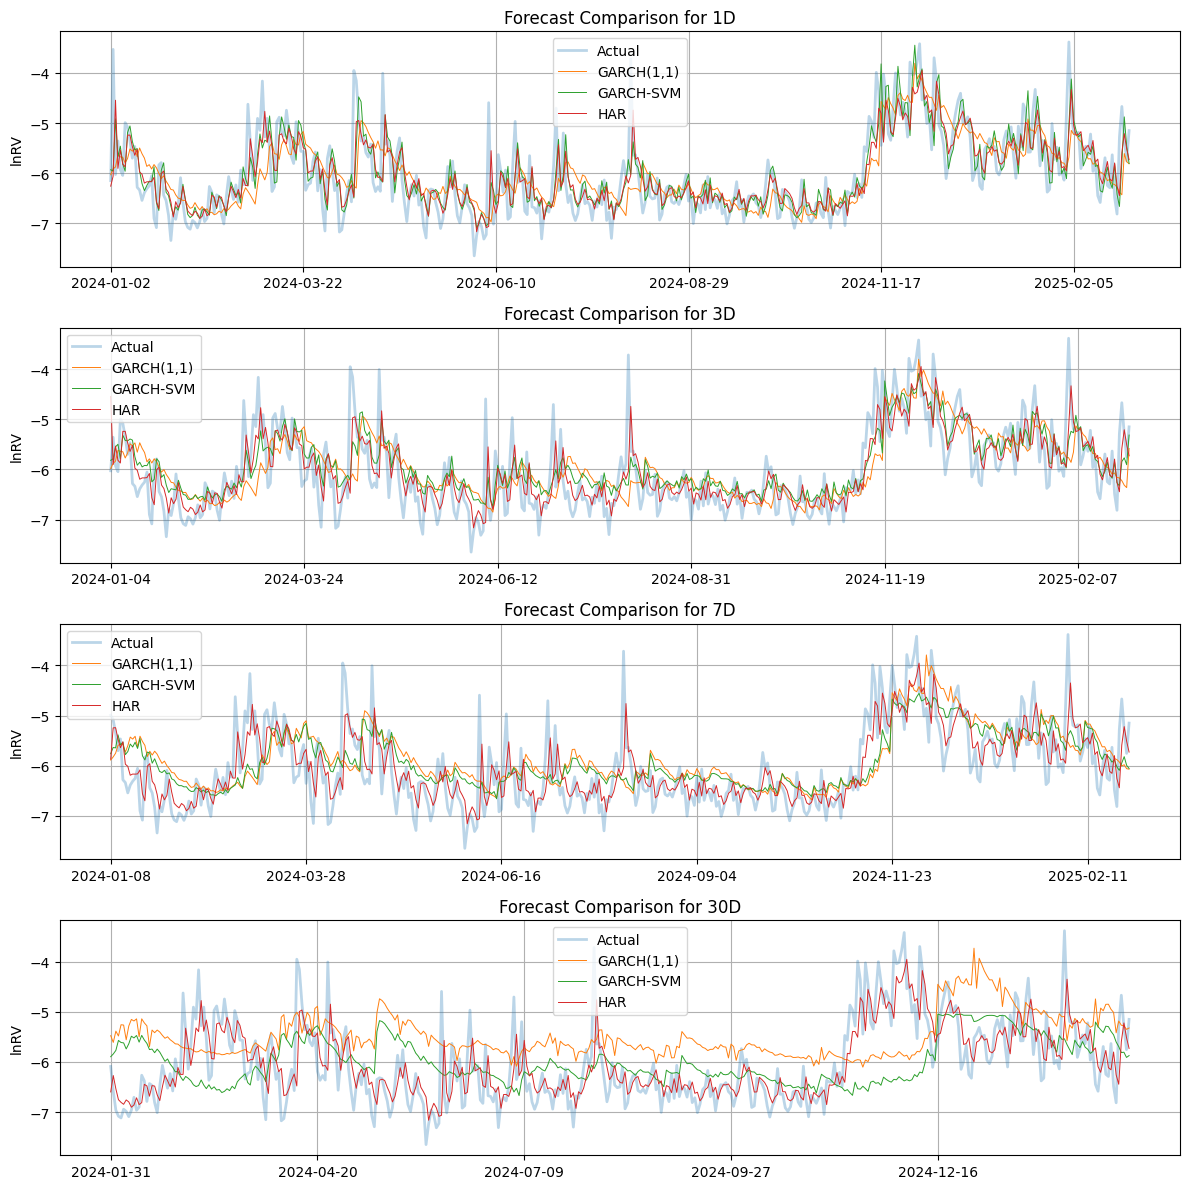

In [18]:
# plotting forecast values together
i = 0
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
for h in [1,3,7,30]:

    # load data
    garch = pd.read_csv(f'../res/GARCH(1,0,1)_{h}D.csv')['Predicted']
    har = pd.read_csv(f'../res/HAR(1, 7, 30)_{h}D.csv')['Predicted']
    garch_svm = pd.read_csv(f'../res/GARCH-SVM_{h}D.csv')['Predicted']
    actual = pd.read_csv(f'../res/lnRV_test_{h}D.csv')
    actual.set_index('Date', inplace=True)

    ax[i].plot(actual['lnRV'], label='Actual', linewidth=2, alpha=0.3)
    ax[i].plot(garch, label='GARCH(1,1)', linewidth=0.7)
    ax[i].plot(garch_svm, label='GARCH-SVM', linewidth=0.7)
    ax[i].plot(har, label='HAR', linewidth=0.7)
    ax[i].set_title(f'Forecast Comparison for {h}D')
    ax[i].set_ylabel('lnRV')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xticks(actual.index[::80])
    ax[i].set_xticklabels(actual.index[::80])
    i += 1
plt.tight_layout()
plt.savefig(f'../eval/forecast_comparison_all.png')